# Incomplete Data 

Creating accurate predictions is one of the most valuable skills in the job market today. Statisticians, economists, and data scientists use data gathered from specific populations in order to predict the future. Through computational and statistical techniques, we can make _statistical inferences_ to draw conclusions from data that are often incomplete.

As far as estimations of parameters that already exist, having full population data would mean that our questions about that population are answered. But because the cost of gathering a full set of information typically outweigh the benefits of having perfectly accurate data, we are okay with use data samples to draw inferences about past data and predict future observations. 

## Are Mutual Funds better than Broad-market index funds? 

The term “index fund” refers to the investment approach of a fund. Specifically, it is a fund that that aims to match the performance of a particular market index, such as the S&P 500 or Russell 2,000. The index fund simply tries to match the market. This differs from a more actively managed fund, in which investments are picked by a fund manager in an attempt to beat the market. The age old question is: are the fees payed to an actively-managed mutual fund worth it? 

We could simply compare the mean return from a given date range for a mutual fund and compare it to the S&P500s mean return from the same time interval, and see which is higher. But the fact that mutual funds have a limited number of time intervals which we can sample means we cannnot rule out the possibility that higher or lower returns from the fund were a result of random variation, and not an indicator of the true quality of the fund. Returns to investment in the S&P500 is a quality proxy for returns in equity markets. Although returns to the S&P 500 experience stochasticity, on average the average rate of return from a mutual fund data should beat S&P returns on average if active investment is actually improving the rate of return. So, we need to analyze the two funds using statistical techniques which account for random variation that is possible from incomplete data. 

We would like to ananlyze which(if any) mutual funds have out-performed the market, fees included. To start, we read the CSV downloaded from [Stock Market MBA](https://stockmarketmba.com/listoftop100activelymanagedusstockmutualfunds.php), which shows the 100 largest actively-managed mutual funds in the US. 

In [1]:
import numpy as np
import pandas as pd

mutual_fund_data = pd.read_csv("Top100MutualFunds.csv")
mutual_fund_data

,Symbol,Name,Category1,Category2,Category3,Morningstar Category,Morningstar Rating,Market cap,Current yield,Fees,Action
0,AGTHX,American Funds The Growth Fund of America Class A,US Equity,Broad market,Large cap,Large Growth,3.0,"$138,592,080,000",0.22%,0.62%,Analyze
1,FCNTX,Fidelity Contrafund Fund,US Equity,Broad market,Large cap,Large Growth,3.0,"$121,762,870,000",0.00%,0.74%,Analyze
2,CWMAX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.46%,0.63%,Analyze
3,CWMCX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",0.79%,1.40%,Analyze
4,CWMEX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.28%,0.87%,Analyze
...,...,...,...,...,...,...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.51%,Analyze
96,FDYZX,Franklin DynaTech Fund Advisor Class,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.62%,Analyze
97,BBVLX,Bridge Builder Large Cap Value Fund,US Equity,Broad market,Large cap,Large Value,4.0,"$9,500,000,000",1.55%,0.25%,Analyze
98,PEYAX,Putnam Large Cap Value Fund Class A,US Equity,Broad market,Large cap,Large Value,4.0,"$9,393,340,000",1.23%,0.91%,Analyze


We don't need to include every category for each fund. Let's drop all categories except for the Morningstar Category. We'll also drop the Morningstar Rating and Action columns.

In [2]:
to_drop = [
    "Category2", "Category1", "Category3", "Morningstar Rating",
    "Current yield", "Action"
]
mutual_fund_data = mutual_fund_data.drop(columns=to_drop)
mutual_fund_data

,Symbol,Name,Morningstar Category,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,Large Growth,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,Large Growth,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.87%
...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,Large Growth,"$9,600,000,000",0.51%
96,FDYZX,Franklin DynaTech Fund Advisor Class,Large Growth,"$9,600,000,000",0.62%
97,BBVLX,Bridge Builder Large Cap Value Fund,Large Value,"$9,500,000,000",0.25%
98,PEYAX,Putnam Large Cap Value Fund Class A,Large Value,"$9,393,340,000",0.91%


The symbols column from *mutual_fund_data* contains the ticker symbol that we can use to download data from each fund.  If you have not yet done so, install the module using:

In [3]:
#!pip install pandas-datareader

Next we need to prepare to download the data. We can save the list of symbols and pass each symbol to pandas_datareader. We also need to choose the range of dates to include. Finally, we will save each fund in a dictionary using the ticker sympol as the key for data for that symbol.

In [4]:
import pandas_datareader as web
import datetime as dt

mutual_fund_dict = {}
symbols = mutual_fund_data["Symbol"][25:50]
# will only analyze the first 25 funds for now, but this should illustrate how to do it for any fund
start = dt.datetime(1980, 1, 1)
end = dt.datetime.today()
(start, end, symbols)

(datetime.datetime(1980, 1, 1, 0, 0),
 datetime.datetime(2022, 6, 28, 15, 3, 12, 465018),
 25    EAGRX
 26    AMRMX
 27    FMAGX
 28    HACAX
 29    FLPSX
 30    PRGFX
 31    PRNHX
 32    DFQTX
 33    DFEOX
 34    FLPKX
 35    RPMGX
 36    FOCPX
 37    CNGAX
 38    CNGCX
 39    CNGEX
 40    CNGFX
 41    FNEFX
 42    FOCKX
 43    DFLVX
 44    CDDRX
 45    CDDYX
 46    CDIRX
 47    CVIRX
 48    TWCUX
 49    EGFFX
 Name: Symbol, dtype: object)

Now we are ready to download the data. 

In [5]:
#pull mutual fund data for the longest timeframe avaliable
fund_data = web.DataReader(
    symbols, 
    'yahoo', 
    start=start,
    end=end) 

In [6]:
fund_data

Attributes  Adj Close                                                         \
Symbols         EAGRX      AMRMX      FMAGX      HACAX      FLPSX      PRGFX   
Date                                                                           
1980-01-02        NaN        NaN   0.107513        NaN        NaN   2.061037   
1980-01-03        NaN        NaN   0.107445        NaN        NaN   2.052252   
1980-01-04        NaN        NaN   0.110433        NaN        NaN   2.075094   
1980-01-07        NaN        NaN   0.111656        NaN        NaN   2.074912   
1980-01-08        NaN        NaN   0.113014        NaN        NaN   2.124097   
...               ...        ...        ...        ...        ...        ...   
2022-06-21  58.299999  47.509998  10.690000  65.000000  46.849998  67.730003   
2022-06-22  58.029999  47.500000  10.740000  64.989998  46.410000  67.669998   
2022-06-23  57.880001  47.689999  10.960000  66.150002  46.279999  69.089996   
2022-06-24  59.180000  48.770000  11.280000  68.669998  47.360001  71.580002   
2022-06-27  59.320000  48.830002  11.200000  68.019997  47.709999  70.739998   

Attributes                                              ... Volume        \
Symbols         PRNHX      DFQTX      DFEOX      FLPKX  ...  CNGFX FNEFX   
Date                                                    ...                
1980-01-02   0.626549        NaN        NaN        NaN  ...    NaN   NaN   
1980-01-03   0.615229        NaN        NaN        NaN  ...    NaN   NaN   
1980-01-04   0.622612        NaN        NaN        NaN  ...    NaN   NaN   
1980-01-07   0.606167        NaN        NaN        NaN  ...    NaN   NaN   
1980-01-08   0.612685        NaN        NaN        NaN  ...    NaN   NaN   
...               ...        ...        ...        ...  ...    ...   ...   
2022-06-21  46.150002  26.680000  29.400000  46.810001  ...    0.0   0.0   
2022-06-22  46.549999  26.590000  29.299999  46.369999  ...    0.0   0.0   
2022-06-23  48.709999  26.760000  29.500000  46.230000  ...    0.0   0.0   
2022-06-24  50.520000  27.610001  30.430000  47.310001  ...    0.0   0.0   
2022-06-27  50.000000  27.629999  30.420000  47.660000  ...    0.0   0.0   

Attributes                                                  
Symbols    FOCKX DFLVX CDDRX CDDYX CDIRX CVIRX TWCUX EGFFX  
Date                                                        
1980-01-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1980-01-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1980-01-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1980-01-07   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1980-01-08   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...          ...   ...   ...   ...   ...   ...   ...   ...  
2022-06-21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-06-22   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-06-23   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-06-24   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-06-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10713 rows x 150 columns]

The column names have two layers. We are interested in the adjusted close data. Save this data as a unique dataframe, *close_data*, by selecting the key "Adj Close" from *fund_data*.

In [7]:
close_data = fund_data["Adj Close"]
close_data

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,CNGFX,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,NaN,0.107513,NaN,NaN,2.061037,0.626549,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,0.107445,NaN,NaN,2.052252,0.615229,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,0.110433,NaN,NaN,2.075094,0.622612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,0.111656,NaN,NaN,2.074912,0.606167,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,0.113014,NaN,NaN,2.124097,0.612685,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-21,58.299999,47.509998,10.690000,65.000000,46.849998,67.730003,46.150002,26.680000,29.400000,46.810001,...,42.020000,42.860001,13.82,40.250000,27.820000,27.860001,27.350000,27.850000,60.639999,34.000000
2022-06-22,58.029999,47.500000,10.740000,64.989998,46.410000,67.669998,46.549999,26.590000,29.299999,46.369999,...,41.959999,42.799999,13.77,39.959999,27.790001,27.830000,27.330000,27.820000,60.619999,34.110001
2022-06-23,57.880001,47.689999,10.960000,66.150002,46.279999,69.089996,48.709999,26.760000,29.500000,46.230000,...,42.560001,43.410000,13.98,39.849998,27.900000,27.950001,27.440001,27.940001,61.669998,35.130001


We will want to compare the returns earned by each fund to the returns earned by investment in the S&P 500 index. We will save the S&P 500 data as a new column in the same data frame, *close_data*.

In [8]:
close_data["S&P 500"] = web.DataReader(
    '^GSPC', 
    'yahoo', 
    start=start,
    end=end)['Adj Close']
close_data

<ipython-input-8-d72833c5dd84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data["S&P 500"] = web.DataReader(


Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,NaN,0.107513,NaN,NaN,2.061037,0.626549,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.760002
1980-01-03,NaN,NaN,0.107445,NaN,NaN,2.052252,0.615229,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.220001
1980-01-04,NaN,NaN,0.110433,NaN,NaN,2.075094,0.622612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.519997
1980-01-07,NaN,NaN,0.111656,NaN,NaN,2.074912,0.606167,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.809998
1980-01-08,NaN,NaN,0.113014,NaN,NaN,2.124097,0.612685,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-21,58.299999,47.509998,10.690000,65.000000,46.849998,67.730003,46.150002,26.680000,29.400000,46.810001,...,42.860001,13.82,40.250000,27.820000,27.860001,27.350000,27.850000,60.639999,34.000000,3764.790039
2022-06-22,58.029999,47.500000,10.740000,64.989998,46.410000,67.669998,46.549999,26.590000,29.299999,46.369999,...,42.799999,13.77,39.959999,27.790001,27.830000,27.330000,27.820000,60.619999,34.110001,3759.889893
2022-06-23,57.880001,47.689999,10.960000,66.150002,46.279999,69.089996,48.709999,26.760000,29.500000,46.230000,...,43.410000,13.98,39.849998,27.900000,27.950001,27.440001,27.940001,61.669998,35.130001,3795.729980


Since data for many of the funds considered do not span many years, we will compare monthly returns for each fund to monthly returns to the S&P 500.

To do this, we use the Pandas _.resample("M")_ method, with the "M" specifying that we would like a monthly frequency. Then, we take the _.pct_change()_ on our monthly data.  

In [9]:
monthly_close_data = close_data.resample("M").first()
monthly_close_data.head()

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,NaN,0.107513,NaN,NaN,2.061037,0.626549,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.760002
1980-02-29,NaN,NaN,0.121028,NaN,NaN,2.198787,0.653797,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.120003
1980-03-31,NaN,NaN,0.120213,NaN,NaN,2.129562,0.640762,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.500000
1980-04-30,NaN,NaN,0.106290,NaN,NaN,1.974718,0.567059,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.180000
1980-05-31,NaN,NaN,0.111423,NaN,NaN,2.018439,0.589120,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.459999


In [10]:
#calculate percent change from previous month
monthly_returns = monthly_close_data.pct_change()
monthly_returns.tail()

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-28,-0.000154,-0.013742,-0.099411,-0.119521,-0.025698,-0.112613,-0.134914,-0.048553,-0.048321,-0.025366,...,-0.109966,-0.094695,-0.011656,-0.030162,-0.030425,-0.030677,-0.030435,-0.093518,-0.116558,-0.052125
2022-03-31,-0.022133,-0.028631,-0.060276,-0.079510,-0.029602,-0.070431,-0.036857,-0.038986,-0.041308,-0.029825,...,-0.051556,-0.070646,-0.034287,-0.040077,-0.039705,-0.040457,-0.040038,-0.069398,-0.088224,-0.052849
2022-04-30,0.026721,0.048989,0.055641,0.059642,0.031678,0.030489,-0.007116,0.044721,0.047298,0.031917,...,0.024223,0.051856,0.039273,0.050870,0.050586,0.050337,0.050649,0.062167,0.035026,0.055640
2022-05-31,-0.059094,-0.049840,-0.106881,-0.136545,-0.045110,-0.143961,-0.133939,-0.071248,-0.074807,-0.044972,...,-0.110242,-0.119328,-0.053977,-0.046935,-0.046556,-0.047418,-0.046571,-0.124215,-0.155034,-0.085898
2022-06-30,0.012691,0.013856,-0.021059,-0.073119,0.026399,-0.055842,-0.104818,-0.003409,-0.003098,0.026426,...,-0.034743,-0.055980,0.030954,0.008040,0.008027,0.007501,0.007695,-0.053349,-0.071089,-0.013031


We have successfully wrangled and prepped our data and can now begin statistical analysis on it. 

## Hypothesis Testing

To start, you formulate your __hypotheses__. These are mutually exclusive, falsifiable statements. Only one can be true, and one of them will be true. We create these two hypotheses: 

- The _null_ hypothesis $H_o$: The true means of the the sample populations do not differ.
- The _alternate_ hypothesis $H_a$: The true means of the sample populations do differ.

### 4 Steps of Hypothesis Testing

All hypotheses are tested using a four-step process:

1. State the two hypotheses so that only one can be right. 
2. Formulate an analysis plan, which outlines how the data will be evaluated.
3. Carry out the plan and physically analyze the sample data.
4. Analyze the results and either reject the null hypothesis, or state that the null hypothesis is plausible, given the data.

Hypothesis testing can be done mentally. It would be burdensome to have to state your _null_ and _alternate_ hypotheses, and run through these four steps explicitly every time you made a predictive computer model. The point is that in means testing, there is a clear process and result that deliniates "Yes, the true means of these samples are different" and "No, they're not significantly different"

In the case of us determining the efficacy of an investment strategy, we must compare the return on strategy to the average return approximated by returns on investment in the S&P 500. These are our hypotheses: 

- $H_o$: There is no difference between the mutual fund's and S&P500's average monthly return. 
- $H_a$: The mutual funds have a higher mean gain than the S&P500. 

In particular, we would like to know if the mean returns for any and each index funds are different from and higher than returns earned by the S&P 500.

We can easily calculate the average monthly returns for each fund using the _.mean()_ method. 

In [11]:
avg_monthly_returns = monthly_returns.mean()
avg_monthly_returns

Symbols
EAGRX      0.005035
AMRMX      0.007755
FMAGX      0.010766
HACAX      0.009632
FLPSX      0.011437
PRGFX      0.008283
PRNHX      0.010782
DFQTX      0.008924
DFEOX      0.009052
FLPKX      0.009250
RPMGX      0.011400
FOCPX      0.012946
CNGAX      0.008474
CNGCX      0.007941
CNGEX      0.008061
CNGFX      0.008429
FNEFX      0.010031
FOCKX      0.013199
DFLVX      0.009538
CDDRX      0.010493
CDDYX      0.010527
CDIRX      0.008642
CVIRX      0.010435
TWCUX      0.011449
EGFFX      0.009969
S&P 500    0.008254
dtype: float64

# Comparisons of Means

When dealing with a population of known parameters $\mu$ and $\sigma^2$, we can take any mean $\bar{X}$ gotten from a sample and determine the likelihood that the sample came from out known population, or a population with same mean as our known population. We do this using a z-score: 
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt(n)}}$
    </font>
</h3>

In [12]:
def zscore(data, mu, sigma):
    x_bar = data.mean()
    n = len(data)
    z = (x_bar - mu) / (sigma / np.sqrt(n))
    return z

Since we pulled all of the S&P data for the relevant time period, we have all of the relevant population data for the S&P and for any other fund. We can, for instance, compare the mean return of the S&P from 1995 to 2000 to the overall mean return of the S&P. 

In [13]:
sp500_1995_2000 = monthly_returns["S&P 500"]['1995':'2000']
sp500_1995_2000

Date
1995-01-31    0.022699
1995-02-28    0.024591
1995-03-31    0.032419
1995-04-30    0.033357
1995-05-31    0.024729
                ...   
2000-08-31   -0.021394
2000-09-30    0.057486
2000-10-31   -0.055590
2000-11-30   -0.010451
2000-12-31   -0.074577
Freq: M, Name: S&P 500, Length: 72, dtype: float64

Define $\mu$ and $\sigma$ to be the mean S&P monthly return, and the standard deviation of the monthly returns across the whole dataset.

In [14]:
mu = monthly_returns["S&P 500"].mean()
sigma = monthly_returns["S&P 500"].std()

Plug these values into our _zscore_ function, to find how many standard deviations the mean monthly S&P change from 1995-2000 was from the mean for all S&P monthly returns: 

In [67]:
z = zscore(sp500_1995_2000, mu, sigma)
z

1.4219656908389737

So from 1995 to 2000 the s&P's monthly return was roughly .16 standard deviations higher than it historically has been. We can plug this value into the standard normal distribution to obtain the probability that this outcome would occur if the mean from 1995 to 2000 truly was the same as the historical S&P monthly returns mean. For this, we can use the same normal distribution function we made in chapter 3. 

In [16]:
# define normal distribution function
def normal_dist(mean , sd, x):
    prob_density = 1/(np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

In [17]:
normal_dist(0, 1, z)

0.11581941144751572

This test suggets that there was a .116 probability of getting this result if the mean monthly S&P return from 1995-2000 truly was the same as the overall mean. This is high, and the general cutoff for "statistical significance" is less than 0.05. So this result is non-significant, and we choose to reject the alternate hypothesis that the S&P had a different mean monthly return from 1995 to 2000 than it had historically. 

## T-values

The t-value, returned from the __T-test__ is used when we are dealing with a population of unknown distribution, and would like to compare a given sample mean to one of three options: 

- **One Sample T-test:** The one sample t test compares the mean of your sample data to a known value. For example, we can compare a given funds average monthly return to some arbitrary value, like 7% or 10%. 
<h3 align="center">
    <font size="7">
        $ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
    
    
   - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
   - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean

In [144]:
from datlib.stats import *

def t_value_1samp(data, mu):
    x_bar = np.mean(data)
    s = np.std(data)
    n = len(data)
    df = n - 1
    t = (x_bar - mu) / (s / np.sqrt(n))
    return t, df

- **Independent Samples T-test:** The The independent samples t test (also called the unpaired samples t test) is the most common form of the T test. It helps you to compare the means of two sets of data. Normally, we are checking to see if the means of the data are significantly different from a differnece of zero. But , we can also check if they are significantly different from a hypothesized or theoretical value. For instance, say we had two groups of males and one group of females and we wanted to compare average heights between the groups. For the males, we would check to see if they differed significantly from an average height difference of zero, whereas when comparing the males to the females we may want to see if they were significantly different from an average difference of 2 inches, or whatever the average height between males and females is. **This hypothesized difference, $(\mu_1 - \mu_2)$, will usually be zero, but not always.**

<h3 align="center">
    <font size="7">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 
    
   
   - Note that this t-test is one variation of the independent samples t-test that _does not_ assume equal variance between the samples
   
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    

In [130]:
# independent samples t-test, setting equal_var=True will turn this test into a paired samples t-test where equal variance
# is assumed
def t_value_ind_samp(a, b, hypothesized_difference=0, equal_var=False):
    
    s1 = np.var(a)
    s2 = np.var(b)
    n1 = len(a)
    n2 = len(b)
    
    # if paired samples, df calculation is different
    if (equal_var):
        df = n1 + n2 - 2
        svar = ((n1 - 1) * s1 + (n2 - 1) * s2) / float(df)
        denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
    else:
        vn1 = s1 / n1
        vn2 = s2 / n2
        df = ((vn1 + vn2)**2) / ((vn1**2) / (n1 - 1) + (vn2**2) / (n2 - 1))
        denom = np.sqrt(vn1 + vn2)

    x_bar1 = np.mean(a)
    x_bar2 = np.mean(b)
    d = np.mean(a) - np.mean(b) - hypothesized_difference
    t = d / denom
    return t, df

- **Paired Samples T-test:** A paired t test (also called a correlated pairs t-test, a paired samples t test or dependent samples t test) is where you run a t test on dependent samples. Dependent samples are essentially connected — they are tests on the same person or thing. This would be useful if we chose a random sample of stores and measured their mean revenues before and after implementation of the new marketing campaign as our two means. For our function, we can simply add an optional argument "equal_var" to our independent t-test funtion which will cause it to act like a paired samples t-test. 

## The T Probability Distribution
When comparing two samples drawn from a population with unknown parameters, we return a t-value(defined below) similar to the z-value, and a corresponding degrees of freedom, indicating the size of our samples. If the size of our samples is high, we can have more confidence in our result. The t-distribution is defined as: 

<h3 align="center">
    <font size="6">
        $ f(T) = \frac{(1 + \frac{T^2}{\nu})^{\frac{-(\nu+1)}{2}}}{B(0.5,0.5\nu)\sqrt(\nu)}$
    </font>
    </h3> 

    
- Where $\nu$ is the degrees of freedom of the distribution and B is the beta function, which is beyond the scope of this book and can be pulled from the scipy.stats library. 
- This is the same distribution shown in the previous chapter; the Cauchy has one degree of freedom and the Standard normal is the form of the t-distribution with more than 30 degrees of freedom

We can implement this distribution in code: 

In [32]:
import datlib.stats
import scipy.special as sc
import scipy.stats as stats

# define a function to create the actual distribution from which we can analyze our t value from the t test
def t_distribution(df, x=np.linspace(-5, 5, 1000)):  # large number of points will ensure accuracy
    # transform flat array of x values into t distribution
    t_distribution = ((1 + x**2 / df)
                      **(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    return t_distribution

And then plot it: 

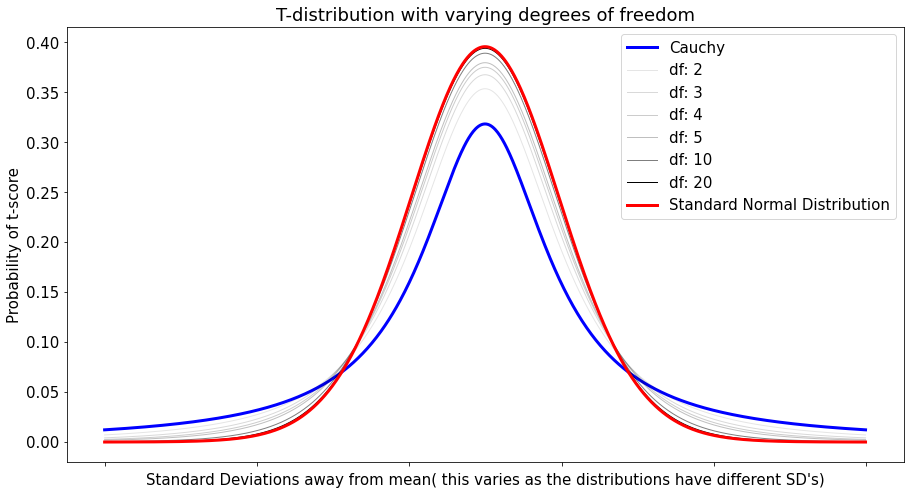

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
cauchy = create_t_distribution(1)
ax.plot(cauchy, '-', lw=3, alpha=1, label="Cauchy", color='b')
t_df = [2, 3, 4, 5, 10, 20]
for df in t_df:
    dist = create_t_distribution(df)
    ax.plot(dist, '-', lw=1, alpha=df / 20, label="df: " + str(df), color='k')
gaussian = create_t_distribution(30)
ax.plot(gaussian,
        lw=3,
        alpha=1,
        color='r',
        label='Standard Normal Distribution')
plt.rcParams.update({"font.size": 15})
ax.set_ylabel("Probability of t-score")
ax.set_xlabel(
    "Standard Deviations away from mean( this varies as the distributions have different SD's)"
)
plt.title("T-distribution with varying degrees of freedom")
ax.set_xticklabels(labels="")
plt.legend()

### T-distribution p-value

As we can see, a lower sample size, and hence a lower degrees of freedom, leads to a lower probaility that our t-score is near 0 when our population means are the same, because more random variation is likely when the sample size is so low. The point of a t-score is to determine if the difference in the two means of the samples is too drastic for the true population means to be the same. As we approach 30 with our degrees of freedom, the graph doesnt change much, and this is a standard normal distribution, which the z-score uses. That is why we can use z-score for large sample sizes. 

Once we get our t-score based on the t-distribution's cumulative density function, shown below. There is a very tedious calculation we could perform to show this CDF manually and plug our t-stat into it, but for our purposes simply using the scipy library will be sufficient. We get a corresponding __p-value__, shown on the y-axis. This value is the probability of our gotten t-value if the true means were the same. 

- If the corresponding p-value from our t-value is too low, we choose to __reject the null hypothesis $H_o$__, and say that our samples come from different populations who's means are different. This is a "statistically significant" result. 


- If the p-value is sufficiently high, we __fail to reject the null hypothesis $H_o$__, and say that there is a high enough chance that the samples came from populations with the same means. This is a "statistically insignificant" result. 


- The value at which a non-significant result becomes a significant one is called the __*critical value*__, denoted $\alpha$, and is most commonly 0.05.

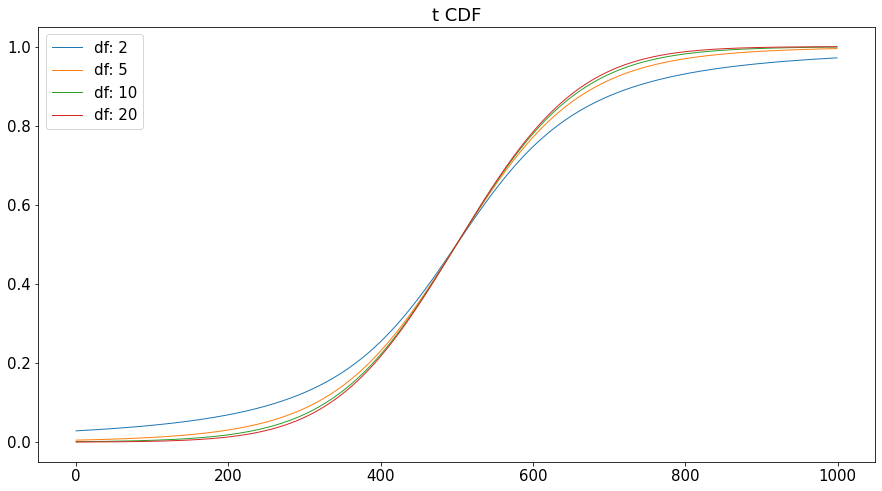

In [107]:
fig, ax = plt.subplots(figsize=(15, 8))

t_df = [2, 5, 10, 20]
for df in t_df:
    x = np.linspace(-4, 4, 1000)
    dist = stats.t.cdf(x, df)
    ax.plot(dist, '-', lw=1, label="df: " + str(df))
plt.title("t CDF")
plt.legend()

Next, we can make a master function that uses all of the t-tests we just built:

In [148]:
from scipy.stats import t

# function that allows us to evaluate the t distribution at a given t value and df
def t_test(a, b, kind):
    
    if kind == 'one_sample': 
            t_val, df = t_value_1samp(a, b)
            print (t_val, df)
    elif kind  == 'independent': 
            t_val, df = t_value_ind_samp(a, b)
    elif kind == 'paired': 
            t_val, df = t_value_ind_samp(a, b, equal_var=True)
            
    p_value = t.cdf(t_val, df)  
    
    if p_value > .05:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."
        
    return return_string

The function accepts $t$ and $\nu$ and returns a probability of the t value occuring if there truly was no difference between the the two sample means, or the single sample mean and one hypothesized mean. If we are intereted in knowing the p that the result is only < or >, we take the p value as is. Otherwise, if we are looking for any difference, we multiply it by 2. If the probability returned is too low, then we can reasonably assume that this means that the two means _are not truly different_. This is the core concept of statistical significance. The probability at which a non-significant difference becomes a significant one is known as the alpha value, and is most commonly 0.05. This means that if there is a less than 5 percent probability that the observed difference in means could have happened by chance, we can reasonably assume that the result didnt happen by chance. 

In [153]:
stats.ttest_ind(prgfx.dropna(), sp500.dropna())

Ttest_indResult(statistic=0.009774724782277915, pvalue=0.9922029411284824)

In [151]:
print(np.mean(sp500), np.mean(prgfx))

0.008253630351886683 0.00828268412698267


In [149]:
sp500 = monthly_returns["S&P 500"]
prgfx = monthly_returns["PRGFX"]
t_test(prgfx, sp500, kind='independent')


'T-value: 0.009793947465114089, P-value: 0.5039061902898071, Fail to reject null hypothesis.'


EAGRX: 
T-value: nan, P-value: nan, Reject null hypothesis.

AMRMX: 
T-value: nan, P-value: nan, Reject null hypothesis.

FMAGX: 
T-value: nan, P-value: nan, Reject null hypothesis.

HACAX: 
T-value: nan, P-value: nan, Reject null hypothesis.

FLPSX: 
T-value: nan, P-value: nan, Reject null hypothesis.

PRGFX: 
T-value: nan, P-value: nan, Reject null hypothesis.

PRNHX: 
T-value: nan, P-value: nan, Reject null hypothesis.


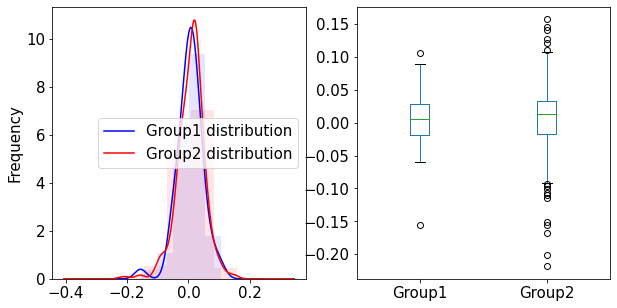

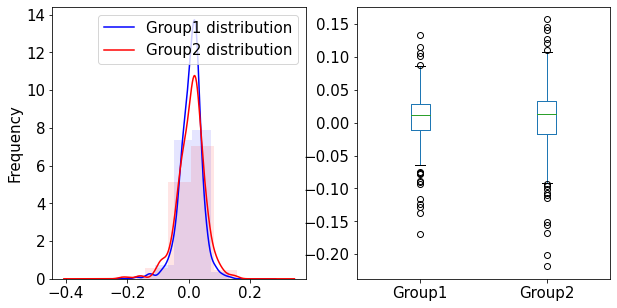

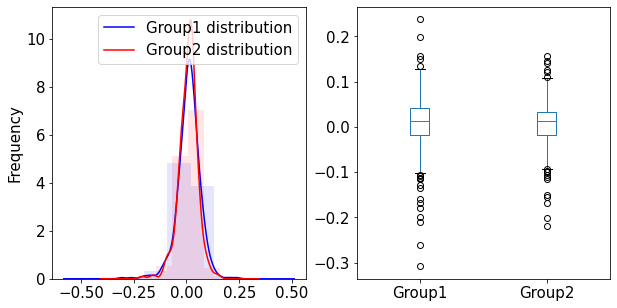

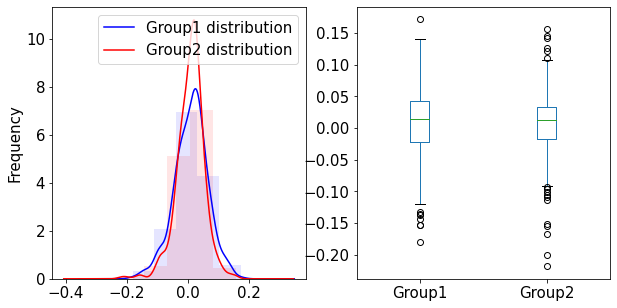

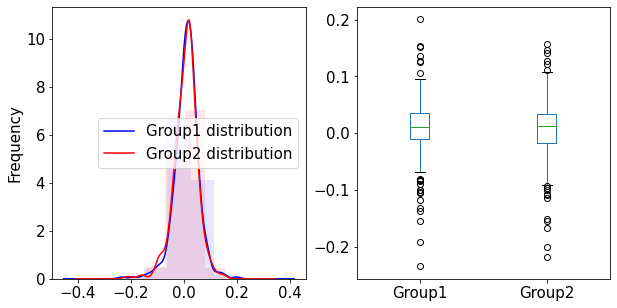

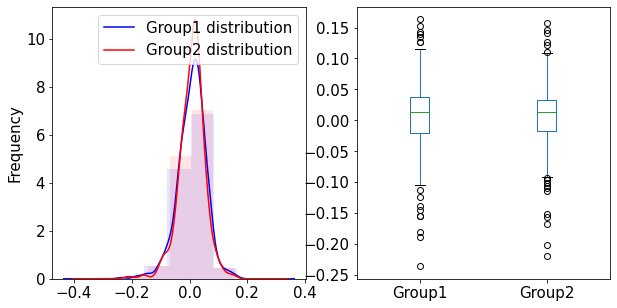

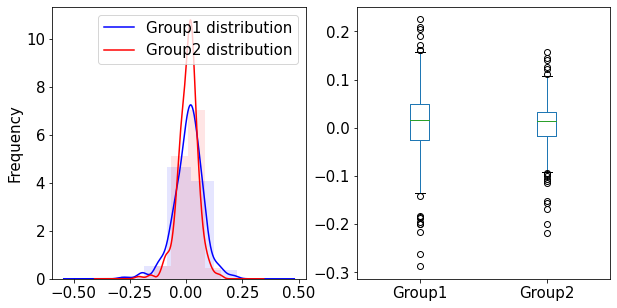

In [129]:
i = 0
for key in monthly_returns.keys():
    print("\n" + key + ": ")
    result = ttest_ind_samp(monthly_returns[key], sp500)
    print(result)
    i += 1
    if i == 7:
        break

The results are not exactly the same but they are reasonably close 

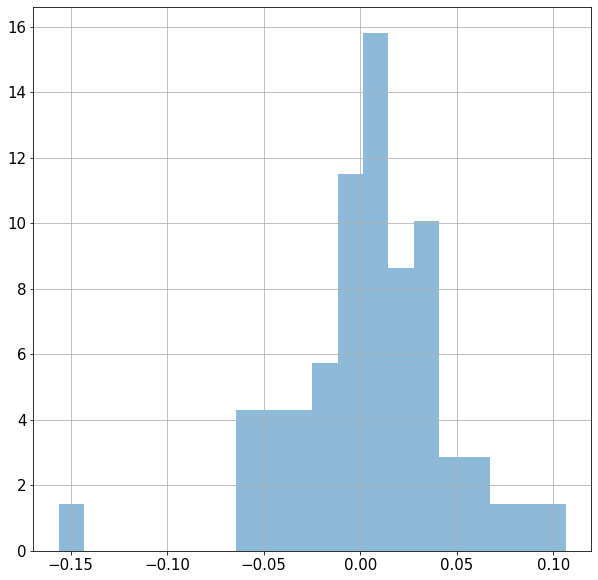

AssertionError: passed axis not bound to passed figure

<Figure size 432x288 with 0 Axes>

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
for key in monthly_returns:
    monthly_returns[key].hist(density = True, alpha=.5, legend = False, ax = ax, bins = 20)
    plt.show()

# ANOVA 

While using T-tests and Z-tests to analyze means of groups, we were restricted to only being able to compare two groups at a time. What if we wanted to see of there was significant differences between more than two groups? The **ANOVA**, or **Analysis of Variance** techniques allow us to test the null hypothesis that there is no significant difference between $k$ (some integer larger than 2) groups. 

- $H_o$: $\mu_1 = \mu_2 = \cdots = \mu_k$
- $H_a$: At least two of the means are not equal. 

### Assumptions needed for ANOVA
There are three assumptions that must be met in order to carry out an ANOVA test: 

1. The experimental errors of yoyr data are normally distributed
2. Homoscedasticity - the variances of your factors are all roughly the same (and at least follow the same distribution)
3. Samples are independent - Selection of one sample had no effect on any other sample

### F-Statistic
The distribution used for the hypothesis test is a new one. It is called the F distribution, named after Sir Ronald Fisher, an English statistician. The F-statistic is a ratio. There are two sets of degrees of freedom; one for the numerator and one for the denominator. 

The F distribution is derived from the t-distribution. The values of the F distribution are squares of the
corresponding values of the t-distribution. One-Way ANOVA expands the t-test for comparing more than two groups.
The scope of that derivation is beyond the level of this textbook. 

To calculate the F ratio, two estimates of the variance are made:

1. **Variance between samples**: An estimate of $\sigma^2$ that is the variance of the sample means multiplied by n (when the sample sizes are the same.). If the samples are different sizes, the variance between samples is weighted to account for the different sample sizes. The variance is also called **variation due to treatment or explained variation.**

2. **Variance within samples**: An estimate of $\sigma^2$ that is the average of the sample variances (also known as a pooled variance). When the sample sizes are different, the variance within samples is weighted. The variance is also called **the variation due to error or unexplained variation.**

- $SS_b$ = the sum of squares that represents the variation among the different samples

- $SS_w$ = the sum of squares that represents the variation within samples that is due to chance.

To find a "sum of squares" means to add together squared quantities that, in some cases, may be weighted. We used sum of squares to calculate the sample variance and the sample standard deviation. 

MS means "mean square." $MS_b$ is the variance between groups, and $MS_w$ is the variance within groups. These measurements are the total sum of squares of their variances divided by the degrees of freedomom of the measure to give a mean value. 

### Caluculating the F-Statistic

- $k$ = the number of different groups
- $n_j$ = the size of the $j^{th}$ group
- $\bar{x_j}$ = the mean of the $j^{th}$ group
- $\bar{x}$ = the grand mean of all values 
- $N$ = total number of all the values combined (total sample size: $\sum{n_j}$)
- $x_i$ = one value: 

- Explained variation: sum of squares representing variation among the different samples:

    - $SS_{b} = \sum_{j = 1}^{k}{n_j(\bar{x_j} - \bar{x})^2}$

- Unexplained variation: sum of squares representing variation within samples:

    - $SS_w = \sum_{j = 1}^{k}{\sum_{i = 1}^{n_j}{(x_i - \bar{x_j})^2}}$
 
- Total variation across the dataset: 

    - $SS_t = SS_b + SS_w$
    
- $df$'s for the numerator(between samples): $df_b = k – 1$
- $df$'s for the denominator($df$'s within samples): $df_w = k – 1$
- Mean square (variance estimate) explained by the different groups:
$MS_b = \frac{SS_b}{df_b} = \frac{SS_b}{k-1}$
- Mean square (variance estimate) that is due to chance (unexplained): $MS_w = \frac{SS_w}{df_w} = \frac{SS_w}{n - k}$

The one-way ANOVA test depends on the fact that $MS_b$ can be influenced by population differences among means of the several groups. Since $MS_w$ compares values of each group to its own group mean, the fact that group means might
be different does not affect $MS_w$. The null hypothesis says that all groups are samples from populations having the same normal distribution. The alternate
hypothesis says that at least two of the sample groups come from populations with different normal distributions. If the null hypothesis is true, $MS_b$ and $MS_w$ should both estimate the same value. 

Finally, we arrive at the **F-Statistic**, which will function for us as the T-Statistic did earlier this chapter, as an input into its density function to recieve a p-value telling us the likelihood of its occurence if our null hypothesis was true. 

- $ F = \frac{MS_b}{MS_w}$

With a density function:
<h3 align="center">
    <font size="5">
        $ f(x, df_1, df_2) = \frac{df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1}}
                        {(df_2+df_1 x)^{(df_1+df_2)/2}
                         \beta(df_1/2, df_2/2)}$
    </font>
    </h3> 



where $df_1$ and $df_2$ are the
shape parameters and
$\beta$ is the beta function.  The formula for the beta function
is
<ul>
$B(a, b) = \int_0^1 t^{a-1}(1-t)^{b-1}dt
        = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$,
 
<p>where <span class="math notranslate nohighlight">\(\Gamma\)</span> is the gamma function.</p>
    
These funtions could be implememnted manually using basic math symbols, but for our purposes, importing them from Scipy will be much more pragmatic. 
    
In a testing context, the F distribution is treated as  "standardized distribution" (i.e., no location or scale parameters).
However, in a distributional modeling context (as with other probability distributions), the F distribution itself can be
transformed with a <a href="eda364.htm">location parameter</a>, $\mu$, and a <a href="eda364.htm">scale parameter</a>, $\sigma$.
<p>

In [ ]:
from scipy.stats import f as f_dist

def SSW(*args):
    args = [arg for arg in args]
    ssw = 0
    for arg in args: 
        group_mean = np.mean(arg)
        val = np.sum((arg - group_mean)**2)
        ssw += val
    return ssw

def SSB(*args):
    args = [arg for arg in args]
    ssb = 0
    alldata = np.concatenate(args)
    grand_mean = np.mean(alldata)
    for arg in args: 
        group_mean = np.mean(arg)
        n = len(arg)
        val = n*((group_mean - grand_mean)**2)
        ssb += val

    return ssb

def get_sum_square_stats(*args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be analyzed. 
        
    Returns
    ------------------
    ssw: float
        Sum-of-squares within the arguments. Tells us how much of the variation
        is due to within-argument variation. 
    
    ssb: Sum-of-squares between arguments. Tells us how much of the variation 
        of the groups is from between-group variation. 
    
    sst: Total sum of squares variation for the list of groups. Tells us how much 
        the samples vary in total. 
        sst = ssw + ssb
    """
    ssw = SSW(*args)
    ssb = SSB(*args)
    sst = ssb + ssw
    return ssw, ssb, sst

def get_anova_counts(args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be counted. 
        
    Returns
    ------------------
    k: int
        number of groups 
    N: int
        total number of observations across all groups
    dfbn: int
        degrees of freedom between arguments; k - 1
    dfwn: int
        degrees of freedom within arguments; n - 1
    """
    k = len(args)
    N = 0
    for i in range(k):
        N += len(args[i])
    dfbn = k - 1
    dfwn = N - k
    
    return k, N, dfbn, dfwn

def show_distributions(args): 
    anova_df = pd.DataFrame(args)
        #for i in range(k):
         #   arg_df = pd.DataFrame(args[i])
          #  pd.merge(anova_df, arg_df, left_index=False)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
    i = 1
    for arg in args:
        arg_df = pd.DataFrame(arg)
        arg_df.plot.kde(ax=axs[0], label="Group "+str(i)+ " distribution", legend=True)
        arg_df.plot.hist(ax=axs[0], bins=5, density=True, alpha=0.1)
        i+=1
       
        
        anova_df.transpose().boxplot(grid=False, ax = axs[1])

def finish_anova(f, dfbn, dfwn): 
     """
    Parameters
    ----------------------
    f: float
         calculated f-value. 
         f = mean-square-between groups / mean-square-within groups
         The f-value is the ratio of how much variation is between versus within groups. 
         If the groups means were the same, the between group variation would be zero. 
         As the f-value grows, the more dissimilar the groups means are. 
    dfbn: int
        Degrees of freedom between groups passed to ANOVA funtion. 
    dfwn: int
        Degrees of freedom within groups. 
        
    Returns
    ------------------
    p: float
        p-value calculated from passing gotten f-value and df's into the f-density funtion from scipy. 
        could attempt to manually implement, i.e
        [f(x, df_1, df_2) = (df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1} / 
        [{(df_2+df_1 x)^{(df_1+df_2)/2}*sc.beta(df_1/2, df_2/2)}\]
        
    return_string: String
        Specifies whether gotten p value implies rejecting or failing to reject the null hypothesis. 
    
    """
    # use scipy to plug f-value into f distribution to return p-value
     p_value = f_dist.sf(dfbn, dfwn, f)
    
     if p_value > .05:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
     else:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

     return return_string

In [ ]:
# use *args command to accept variable number of arguments
def anova(*args):
    
    k, N, dfbn, dfwn  = get_anova_counts(args)
    
    ssw, ssb, sst = get_sum_square_stats(*args)

    msb = ssb / float(dfbn)
    msw = ssw / float(dfwn)
    f = msb / msw
    
    
    if(show_distributions):
        show_distributions(args)

    return finish_anova(f, dfbn, dfwn)

Now that we have built our function, we can test it. In the case of our mutual fund analysis, a relevant ANOVA problem would be comparing mean returns across the categorical variable of fund category. In one of our data columns, "Morningstar Category", Morningstar provides categorizations of funds based of what they focus on. Does one specialization do better than the others? Should investors choose one category of fund over the others? 

In [ ]:
# find what categories are listed in our dataset:
fund_types = mutual_fund_data["Morningstar Category"].unique()
fund_types

In [ ]:
# create lists of categories to be analyzed and pull mean yeary returns for each category
fund_type_returns_dict = {}
for ftype in fund_types:
    fund_type_returns_dict[ftype] = []
    for i in range(25, 50):
        if mutual_fund_data["Morningstar Category"][i] == ftype:
            fund_type_returns_dict[ftype].extend(
                monthly_returns[mutual_fund_data["Symbol"][i]])

In [ ]:
mutual_fund_data["Morningstar Category"]

In [ ]:
fund_type_returns_dict

In [ ]:
fund_type_returns_dict.keys()

There are almost no funds with the last 5 categories so we will just do the analysis on the fist 4. 

In [ ]:
anova(fund_type_returns_dict["Large Growth"],
      fund_type_returns_dict['Large Value'],
      fund_type_returns_dict['Large Blend'],
      fund_type_returns_dict['Mid-Cap Growth'])

Compare to equivalent SciPy function: 

In [ ]:
stats.f_oneway(fund_type_returns_dict["Large Growth"],
               fund_type_returns_dict['Large Value'],
               fund_type_returns_dict['Large Blend'],
               fund_type_returns_dict['Mid-Cap Growth'])

These results suggest that almost all of the total variance in the data is caused by within-data variance, not between-data variance. The practical interperetation is that the type of mutual fund does not significantly change yearly returns. This result may support the EMH because specific specialization of funds has no effect on returns. The market gave the same returns to the funds no matter their specialization. 